In [93]:
ID = "101615093" # your student id

# Assignment 3 - Quantifying Behavior of Groups - Part B


Data from mobile devices are high-resolution, meaning that they are segmented into small time intervals (a few seconds). We often want to **downsample** the data, i.e., binning them into bigger bins, to reduce the signal's noise. In this part, you will learn to process and visualize segmented data by implementing the method introduced in the [reading assignment](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-018-0174-4).


### Table of Contents

* [Section 1: Loading data](#section_1)
* [Section 2: Preprocessing](#section_2)
* [Section 3: Processing segmented data](#section_3)
* [Section 4: Visualizing the Unlocking Activity Pattern ](#section_4)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

if 'AALTO_JUPYTERHUB' in os.environ:
    # using jupyter sharedata directory
    DATA = '/coursedata/pa3/as2/'
    TEST_PATH = '/coursedata/pa3/test/'
else:
    DATA = '../../data/pa3/as2/'
    TEST_PATH = '../../data/pa3/test/'

# define global plotting parameters
plt.rcParams.update({'font.size':20})
sns.set(style="dark", font_scale=2)

## 1. Loading data <a class="anchor" id="section_1"></a>

The dataset consists of multiple `csv` files which contain cellphone screen activity records.

You can get the paths of all records by calling the `os.listdir()` function.

In [2]:
files = os.listdir(DATA)

print(files[:5])

['u81ac42.csv', 'u54962c.csv', 'u564837.csv', 'u56a637.csv', 'u57ea3e.csv']


Each `csv` file corresponds to one subject. The name of the `csv` file can be seen as the `Id` of the subject.

In [3]:
# get one sample data
pd.read_csv(DATA + files[0]).head()

,ts,Screen_Value
0,2016-06-09 14:10:10,Unlocked
1,2016-06-09 14:10:58,Off
2,2016-06-09 14:10:59,On
3,2016-06-09 14:12:52,Unlocked
4,2016-06-09 14:13:15,Off


The csv file contains the following columns:

1. `ts`: universal timestamp
2. `screen_value`: type of activity, can be either **Unlocked**, **Off** or **On**

---

## 2. Preprocessing <a class="anchor" id="section_2"></a>


In this task, we will compute **the daily activity pattern of each subject**. Let's break down the tasks into smaller steps.

&#x1F4DD; **Task:**

- **Step 1: Count the number of unlocking events in each hour for each user.**

    - For each user, we want to count how many times they unlock their phone during each hour of the day.
    - Example: The **24 bins** represent 24 hours where the first bin counts all unlocking attempts that happened **during the period of 00:00-00:59**, and the second bin from **01:00-01:59**, etc.


- **Step 2: Aggregate the counts across the bins for each user.**

    - After counting for each user, aggregate these counts to find the total number of unlocking events for each hour, considering all the days they were part of the study.
    - Example: Let's consider User A who stayed in the study for 2 days:

        - **User A:**

            - **Day 1:**

                - 9:00 AM - 5 unlocks

                - 10:00 AM - 7 unlocks

            - **Day 2:**

                - 9:00 AM - 4 unlocks

                - 10:00 AM - 6 unlocks

    - Now, you will want to aggregate these counts:

        - **User A:**

            - 9:00 AM - (5 + 4) = 9 unlocks

            - 10:00 AM - (7 + 6) = 13 unlocks

- **Step 3: Average by dividing the values by the number of days the user remained in the study.**

    - To get an average daily activity pattern, we divide the aggregated counts by the number of days each user was in the study.
    - Example: User A was in the study for 7 days. So, for 9:00 AM, the average count would be (total count for 9:00 AM) / 7.

- **Step 4: Normalize the final values.**

    - Finally, we can normalize the values to make them relative, often between 0 and 1, so they represent proportions or percentages.

&#128161; Hints:
- When reading data from csv-files, you must convert the 'date' column into an appropriate data type using the [pd.to_datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) function.
- You can use the following functions: [dt.hour](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.hour.html) and [value_counts()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html?highlight=value_counts#pandas.Series.value_counts)
- There might be **missing records** for specific hours. Fill those empty records with **0**.

In [94]:
# save intermediate results 
df = pd.DataFrame()
res = {}

# recursively read records
for i in files:
    # read one record at a time
    record = pd.read_csv(os.path.join(DATA, i))
    
    # user's id, used to form the final dataframe
    uid = i.split(".")[0]
    
    # Storing subject results in this dictionary. The keys are the hour and the values are the average unlocking attempts per hour
    # Example: {'0': 1.2, '1': '2.3',...,'23':0.1}
    u_res = {}
    
    # convert the 'ts' column into datetime
    record['ts'] = pd.to_datetime(record['ts'])
    days = len(record['ts'].dt.date.unique())
    
    # filter out the unlocking events
    unlock_events = record[record['Screen_Value'] == 'Unlocked']
    
    
    for i in range(24):
        u_res[i] = (unlock_events[unlock_events['ts'].dt.hour == i].shape[0])/days
    
    # save result into dict
    res[uid] = u_res
    
# generate result dataframe and normalizing
df = pd.DataFrame().from_dict(res)

# fill missing values with 0
df.fillna(0, inplace=True)

# normalizer
scaler = StandardScaler()
columns = df.columns

# apply normalization to the DataFrame
df = pd.DataFrame(scaler.fit_transform(df), columns=columns)

# unit test
assert df.shape == (24, 342) or df.shape == (342,24), "wrong shape of DataFrame"
assert round(df.iloc[0,0], 2) == -1.16


In [60]:
df.head()

,u81ac42,u54962c,u564837,u56a637,u57ea3e,u5866e7,u5886c3,u588dba,u5a6585,u5b7a17,...,ud7a098,ud7a6a4,ud8994e,ud8c991,ud97fd1,ud9b6cf,udafa4f,udb37c2,udb4d95,udc3f3d
0,-1.162277,-0.168738,0.500636,0.133449,-0.759955,-0.808101,-0.554748,-1.462231,-0.904924,0.625472,...,1.003754,-0.099963,-0.024418,-1.091139,1.381302,-0.990842,-1.210720,-0.883888,-0.563942,-0.332070
1,-1.490449,1.265008,-1.185717,-1.336680,-0.844787,-0.747016,-1.192664,-1.514145,-1.197848,-0.013308,...,-0.239903,-1.162425,-1.196470,-1.575562,2.117997,-1.189010,-1.360964,-1.380105,-0.607532,-1.290827
2,-1.490449,-0.143584,-1.291114,-1.599203,-0.844787,-1.113524,-0.719371,-1.514145,-1.281540,-0.532317,...,-1.345375,-1.265244,-0.823544,-1.319103,1.410770,-1.160700,-1.360964,-1.380105,-0.869070,-1.111060
3,-1.490449,-0.973647,-1.291114,-1.441689,-0.844787,-1.082982,-1.233820,-1.514145,-1.281540,-1.051326,...,-1.575682,-1.402336,-1.356295,-1.689544,-0.180490,-1.189010,-1.360964,-1.380105,-1.566506,-0.991215
4,-1.490449,-1.728250,-1.291114,-1.651707,-0.844787,-1.113524,-1.213242,-1.514145,-1.281540,-1.370716,...,-1.529621,-1.402336,-1.409570,-1.319103,-0.769846,-1.075771,-1.345940,-1.380105,-1.675480,-0.751526


In [ ]:
### HIDDEN TESTS

## 3. Visualizing the Unlocking Activity Pattern <a class="anchor" id="section_4"></a>

By plotting individual data against group data, we can observe the difference between an individual's patterns and their group's [1]. We can classify individuals based on their typical behavior [2]. For example, if someone tends to use the phone late in the evening, we can call them *night owls*. Conversely, we classify the people with opposite behavior as *early birds*.

Now, run the following two cells to see the unlocking activity pattern of subjects against the average.

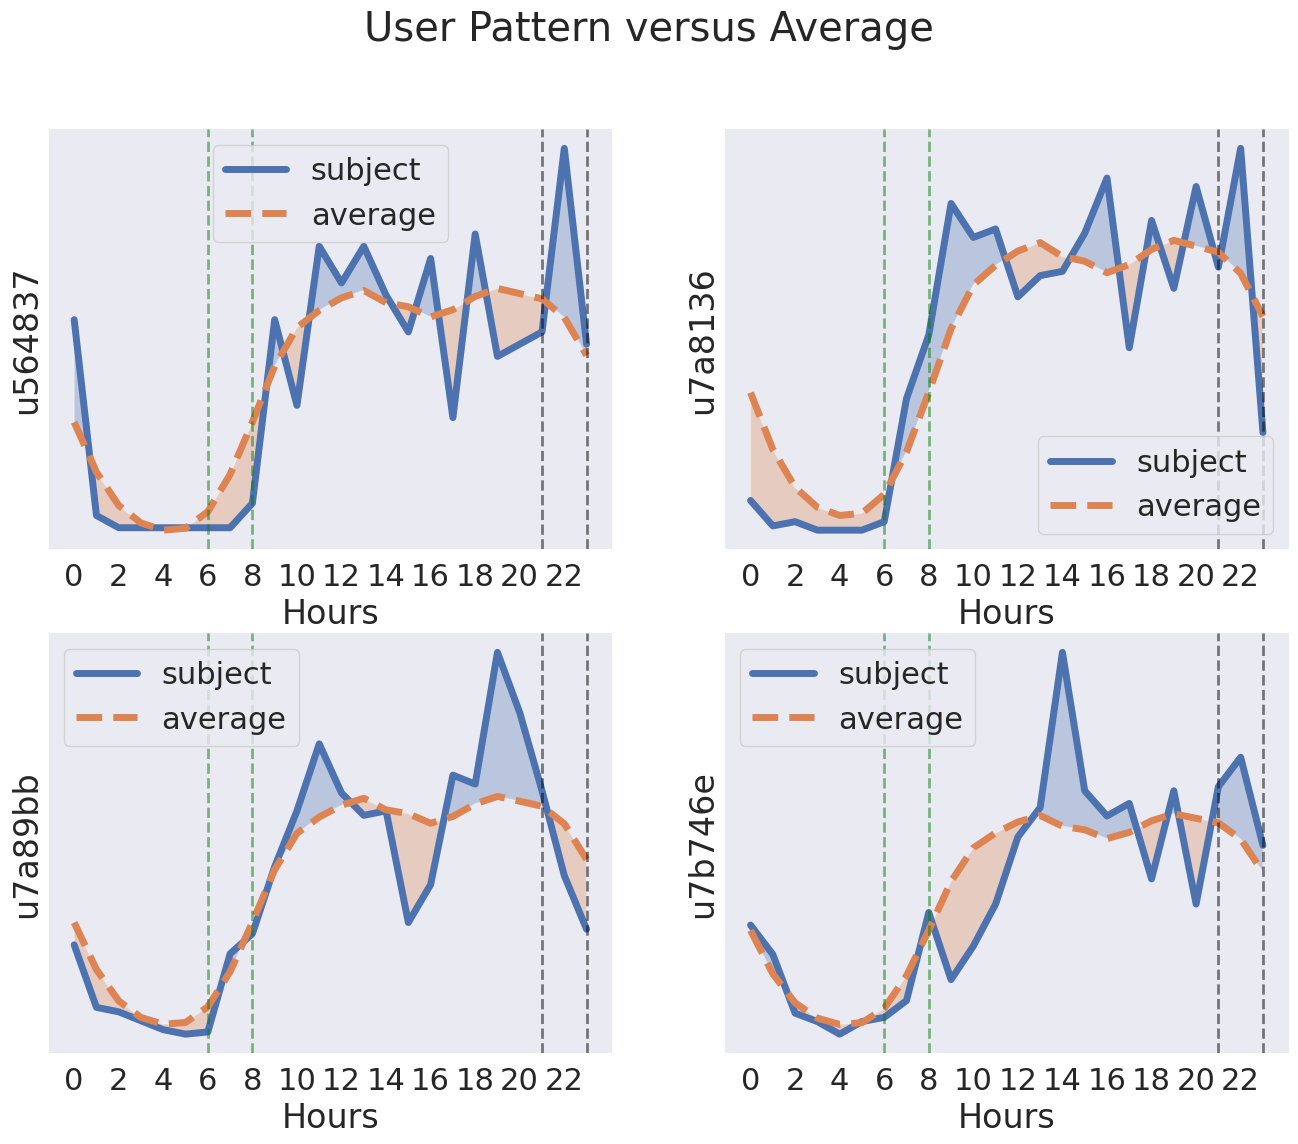

In [61]:
# calculate the average patterns
average = df.mean(axis="columns")

from helper import plot_subject_vs_average

fig, ax = plt.subplots(2,2,figsize=(16,12))

plot_subject_vs_average(df.iloc[:, 2], ax[0,0], average)
plot_subject_vs_average(df.iloc[:, 15], ax[0,1], average)
plot_subject_vs_average(df.iloc[:, 16], ax[1,0], average)
plot_subject_vs_average(df.iloc[:, 17], ax[1,1], average)

# plt params
sns.despine(top=True, right=True, left=True, bottom=True)
fig.suptitle("User Pattern versus Average")

# plt.tight_layout()
plt.show()

### Task: Naive classifier (extra 1 point)  
In this task, you will have to implement a naive classifier, which identifies a person as either an early bird or a night owl, based on the relative sum of areas between the personal pattern and the average pattern in the period of 6-8 and 21-23. The person can be classified as an *early bird* if the morning screen activity is higher than the average level and the evening screen activity is lower than the average level. 

In the morning, between **6-8 (closed from both sides)**, the area enclosed by the **blue line at the top** and the **yellow line at the bottom** is regarded as a **positive** value, vice-versa. In the evening between **21-23**, the area enclosed by the **blue line at the top** and the **yellow line at the bottom** is regarded as a **negative** value.

Now, if the sum of the area between 6-8 and 21-23 is positive, we identify that person as an *early bird*, and vice-versa.

&#x1F4DD; **Task:**

- Implement the function in the below cell and then answer the question:
- **Q: Is subject `uf3f17f` an early bird?**

In [92]:
def classifier(x: pd.Series) -> bool:
    """
    Returns:
        True for early bird, False for night owl
    """
    morning_hours = x[6:8]
    evening_hours = x[21:23]
    morning_avg = average[6:8]
    evening_avg = average[21:23]
    morning_area = (morning_hours - morning_avg).sum()
    evening_area = (evening_hours - evening_avg).sum()
    total_area = morning_area - evening_area
    
    #if total_area > 0:
        #print("Early Bird")
    #else:
        #print("Night Owl")
    
    return bool(total_area > 0) #(True or False)
    
assert classifier(df["u184979"]) == True, "Maybe check the description again?"

Q1 = classifier(df["uf3f17f"])   # set True for early bird and False for night owl

assert isinstance(Q1, bool)

In [ ]:
### HIDDEN TESTS

# References

[1] Aledavood T, López E, Roberts SGB, Reed-Tsochas F, Moro E, Dunbar RIM, et al. (2015) Daily Rhythms in Mobile Telephone Communication. PLoS ONE 10(9): e0138098. https://doi.org/10.1371/journal.pone.0138098

[2] Aledavood T, Lehmann S and Saramäki J (2015) Digital daily cycles of individuals. Front. Phys. 3:73. https://doi.org/10.3389/fphy.2015.00073